## Evaluate the feature importances and train/test feature distribution ## 

In [19]:
local = True
if local:
  from google.colab import drive
  drive.mount('/content/drive')
  %cd /content/drive/MyDrive/'Kaggle Otto Reccommender'/data
  path_to_module = '/content/drive/MyDrive/Kaggle Otto Reccommender/'
else:
  !mkdir /my_mnt_dir
  !google-drive-ocamlfuse /my_mnt_dir
  %cd /my_mnt_dir/'Kaggle Otto Reccommender'/data
  path_to_module = '/my_mnt_dir/Kaggle Otto Reccommender/'

import sys    
sys.path.append(path_to_module)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Kaggle Otto Reccommender/data


In [20]:
!pip install shap
!pip install polars
!pip install xgboost --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
import glob
import numpy as np
import pandas as pd
import gc
import polars as pl
import xgboost as xgb
from sklearn.model_selection import GroupKFold
import shap

import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
# Load the training data
path_to_training_data = './train_training_data'
training_data = pl.read_parquet(f'{path_to_training_data}/training_data_2.parquet', n_rows=100_000)
training_data = training_data.drop(['train_aid_penetration', 'percent_of_test_weeks_interacted'])
training_data = training_data.to_pandas()

training_data.replace([np.inf, -np.inf], np.NaN, inplace=True)

for column in training_data.columns:
  if training_data[column].dtype in ('Int32', 'float64', 'Int16'):
    training_data[column] = training_data[column].astype('float32')

In [23]:
# Get a single fold to calculate feature importance
skf = GroupKFold(n_splits=5)
response = ['click_response']
features = [feature for feature in training_data.columns if feature not in ['session', 'aid', 'click_response', 'cart_response', 'order_response']]
for fold, (train_idx, valid_idx) in enumerate(skf.split(training_data, training_data[response], groups=training_data['session'])):
    train_groups = training_data.loc[train_idx].groupby('session', as_index=False).agg({'aid' : 'count'}).aid.values.tolist()
    X_train = training_data.loc[train_idx, features]
    y_train = training_data.loc[train_idx, response]
    dtrain = xgb.DMatrix(X_train)
    dtrain.set_group(train_groups)
    break

## Shap value for clicks model ##

In [24]:
model_name = '../models/xgb_models/clicks_0.xgb'
model=xgb.Booster()
model.load_model(model_name)
model.set_param({'predictor': 'gpu_predictor'})

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

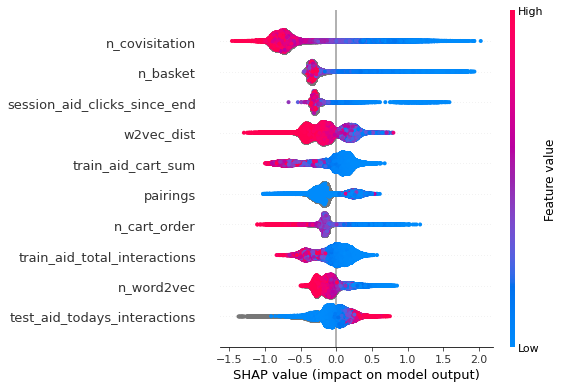

In [25]:
shap.summary_plot(shap_values, X_train, max_display=10)

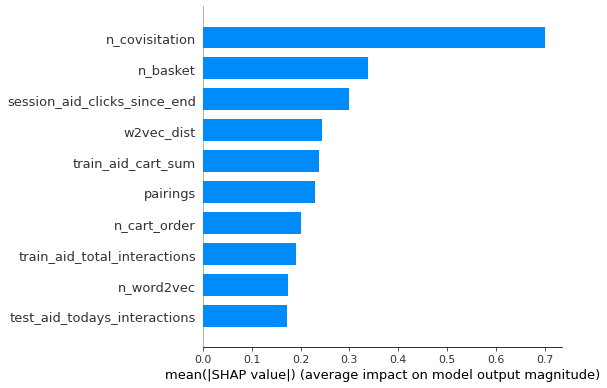

In [26]:
shap.summary_plot(shap_values, X_train, plot_type='bar', max_display=10)

## Shap value for carts model ##

In [27]:
model_name = '../models/xgb_models/carts_0.xgb'
model=xgb.Booster()
model.load_model(model_name)
model.set_param({'predictor': 'gpu_predictor'})

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(dtrain)

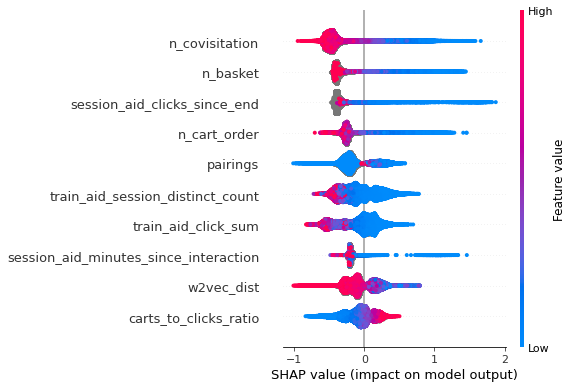

In [28]:
shap.summary_plot(shap_values, X_train, max_display=10)

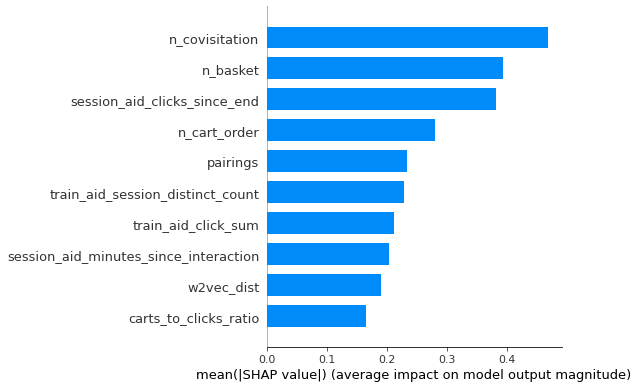

In [29]:
shap.summary_plot(shap_values, X_train, plot_type='bar', max_display=10)

## Shap values for orders model ##

In [30]:
model_name = '../models/xgb_models/orders_0.xgb'
model=xgb.Booster()
model.load_model(model_name)
model.set_param({'predictor': 'gpu_predictor'})

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(dtrain)

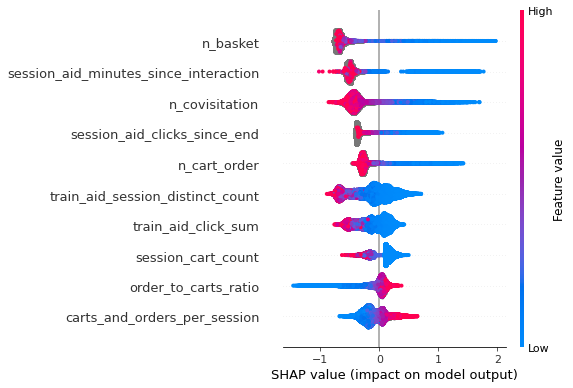

In [31]:
shap.summary_plot(shap_values, X_train, max_display=10)

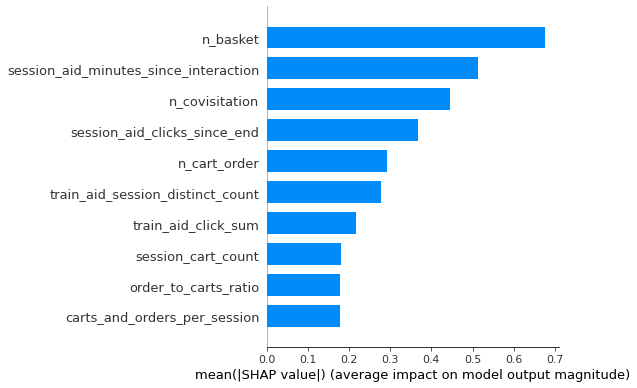

In [32]:
shap.summary_plot(shap_values, X_train, plot_type='bar', max_display=10)

## Check the distribution of train and test features to make sure they match ## 

In [33]:
path_to_testing_data = './test_training_data'
testing_data = pl.read_parquet(f'{path_to_testing_data}/training_data.parquet', n_rows = 100_000)
testing_data = testing_data.with_column(((pl.col('percent_of_test_weeks_interacted') * 4) / (3)).alias('percent_of_test_weeks_interacted'))
testing_data = testing_data.to_pandas()

`with_column` has been deprecated in favor of `with_columns`. This method will be removed in version 0.17.0


count    3243.000000
mean        1.137742
std         1.782511
min         0.071773
25%         0.264227
50%         0.596613
75%         1.000000
max        18.266010
Name: weight, dtype: float64
count    3132.000000
mean        1.035492
std         1.510385
min         0.071773
25%         0.252664
50%         0.594084
75%         1.000000
max        21.095715
Name: weight, dtype: float64


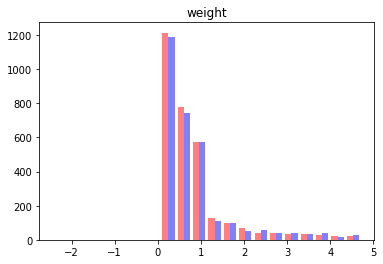

In [34]:
for column in testing_data.columns[2:]:
  testing_x = testing_data[column]
  test_stats = testing_x.describe()
  print(test_stats)
  training_x = training_data[column]
  train_stats = training_x.describe()
  print(train_stats)
  min_range = min(test_stats['mean'] - 2*test_stats['std'], train_stats['mean'] - 2*train_stats['std'])
  max_range = max(test_stats['mean'] + 2*test_stats['std'], train_stats['mean'] + 2*train_stats['std'])
  # min_range = min(test_stats['25%'], train_stats['25%'])
  # max_range = max(test_stats['25%'], train_stats['25%'])
  plt.hist([testing_x, training_x], color=['r','b'], alpha=0.5, bins=20, range=(min_range, max_range))
  plt.title(column)
  plt.show()
  break